# Эксперименты с библиотекой DepGraph

[Ссылка](https://github.com/VainF/Torch-Pruning/) на репозиторий библиотеки.

### Импорт модулей

#### Вариант 1 (рекомендуемый)

Устанавливаем оригинальные версии библиотек.

In [1]:
!pip install torch-pruning torcheval --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Вариант 2 (экспериментальный)

Отключаем проверку pruning rate. Код ниже костыльный, но запускаю в Kaggle, поэтому так наиболее удобно.

In [1]:
!pip install torcheval --upgrade -q
!git clone https://github.com/VainF/Torch-Pruning.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00a 0:00:01
Cloning into 'Torch-Pruning'...
remote: Enumerating objects: 7271, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 7271 (delta 131), reused 107 (delta 107), pack-reused 7102 (from 2)
Receiving objects: 100% (7271/7271), 10.30 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (4842/4842), done.


Изменяем код модуля.

In [2]:
base_pruning_code = """
import math
import typing
import warnings

import torch
import torch.nn as nn

from ... import dependency, ops
from .. import function
from ..importance import OBDCImportance
from .scheduler import linear_scheduler

class BasePruner:


    def __init__(
        self,
        # Basic
        model: nn.Module, # a simple pytorch model
        example_inputs: torch.Tensor, # a dummy input for graph tracing. Should be on the same 
        importance: typing.Callable, # tp.importance.Importance for group importance estimation
        global_pruning: bool = False, # https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#global-pruning.
        pruning_ratio: float = 0.5,  # channel/dim pruning ratio, also known as pruning ratio
        pruning_ratio_dict: typing.Dict[typing.Union[nn.Module, typing.Tuple[nn.Module]], float] = None, # layer-specific pruning ratio. Will cover pruning_ratio if specified. The key of the dict can be a single module or a tuple of modules. The pruning ratio will be shared by all modules in the tuple. 
        max_pruning_ratio: float = 1.0, # maximum pruning ratio. useful if over-pruning happens.
        iterative_steps: int = 1,  # for iterative pruning
        iterative_pruning_ratio_scheduler: typing.Callable = linear_scheduler, # scheduler for iterative pruning.
        ignored_layers: typing.List[nn.Module] = None, # ignored layers
        round_to: int = None,  # round channels to the nearest multiple of round_to
        isomorphic: bool = False, # enable isomorphic pruning (ECCV 2024, https://arxiv.org/abs/2407.04616) if global_pruning=True. 

        # Advanced
        in_channel_groups: typing.Dict[nn.Module, int] = dict(), # The number of channel groups for layer input
        out_channel_groups: typing.Dict[nn.Module, int] = dict(), # The number of channel groups for layer output
        num_heads: typing.Dict[nn.Module, int] = dict(), # The number of heads for multi-head attention
        prune_num_heads: bool = False, # remove entire heads in multi-head attention
        prune_head_dims: bool = True, # remove head dimensions in multi-head attention
        head_pruning_ratio: float = 0.0, # head pruning ratio
        head_pruning_ratio_dict: typing.Dict[nn.Module, float] = None, # layer-specific head pruning ratio
        customized_pruners: typing.Dict[typing.Any, function.BasePruningFunc] = None, # pruners for customized layers. E.g., {nn.Linear: my_linear_pruner}
        unwrapped_parameters: typing.Dict[nn.Parameter, int] = None, # unwrapped nn.Parameters & pruning_dims. For example, {ViT.pos_emb: 0}
        root_module_types: typing.List = [ops.TORCH_CONV, ops.TORCH_LINEAR, ops.TORCH_LSTM],  # root module for each group
        forward_fn: typing.Callable = None, # a function to execute model.forward
        output_transform: typing.Callable = None, # a function to transform network outputs
        
        # deprecated
        channel_groups: typing.Dict[nn.Module, int] = dict(), # channel grouping
        ch_sparsity: float = None,
        ch_sparsity_dict: typing.Dict[nn.Module, float] = None, 
    ):
        self.model = model
        self.importance = importance

        # Handle deprecated parameters
        if ch_sparsity is not None:
            warnings.warn(
                "ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.")
            pruning_ratio = ch_sparsity
        if ch_sparsity_dict is not None:
            warnings.warn(
                "ch_sparsity_dict is deprecated in v1.3.0. Please use pruning_ratio_dict instead.")
            pruning_ratio_dict = ch_sparsity_dict

        self.pruning_ratio = pruning_ratio
        self.pruning_ratio_dict = pruning_ratio_dict if pruning_ratio_dict is not None else {}
        self.max_pruning_ratio = max_pruning_ratio
        self.global_pruning = global_pruning
        self.isomorphic = isomorphic

        if len(channel_groups) > 0:
            warnings.warn(
                "channel_groups is deprecated. Please use in_channel_groups and out_channel_groups instead.")
            out_channel_groups.update(channel_groups)

        if len(num_heads) > 0:
            out_channel_groups.update(num_heads)

        self.in_channel_groups = in_channel_groups
        self.out_channel_groups = out_channel_groups
        self.root_module_types = root_module_types
        self.round_to = round_to

        # MHA
        self.num_heads = num_heads
        self.prune_num_heads = prune_num_heads
        self.prune_head_dims = prune_head_dims
        self.head_pruning_ratio = head_pruning_ratio

        ###############################################
        # Ignored layers and submodules
        self.ignored_layers = []
        self.ignored_params = []
        if ignored_layers is not None:
            for layer in ignored_layers:
                if isinstance(layer, nn.Module):
                    self.ignored_layers.extend(list(layer.modules()))
                elif isinstance(layer, nn.Parameter):
                    self.ignored_params.append(layer)

        ###############################################
        # Build dependency graph
        self.DG = dependency.DependencyGraph().build_dependency(
            model,
            example_inputs=example_inputs,
            forward_fn=forward_fn,
            output_transform=output_transform,
            unwrapped_parameters=unwrapped_parameters,
            customized_pruners=customized_pruners,
            ignored_params=self.ignored_params,
        )

        ###############################################
        # Iterative pruning
        # The pruner will prune the model iteratively for several steps to achieve the target pruning ratio
        # E.g., if iterative_steps=5, pruning_ratio=0.5, the pruning ratio of each step will be [0.1, 0.2, 0.3, 0.4, 0.5]
        self.iterative_steps = iterative_steps
        self.iterative_pruning_ratio_scheduler = iterative_pruning_ratio_scheduler
        self.current_step = 0
        # channel pruning ratio for each iterative step
        self.per_step_pruning_ratio = self.iterative_pruning_ratio_scheduler(
            self.pruning_ratio, self.iterative_steps
        )
        self.per_step_head_pruning_ratio = self.iterative_pruning_ratio_scheduler(
            self.head_pruning_ratio, self.iterative_steps
        )

        ###############################################
        # Ranking Scopes
        # We will perform ranking within each scope.
        # If a scope only contains one layer, then we do local pruning
        # If a scope contains multiple layers, then global ranking will be applied to the entire scope
        # To manually specify the ranking scope, you can use pass a key-value pair to the pruning_ratio_dict, with a tuple of modules as the key.
        self._layer_to_scope = {}
        # initial channels for different scope. It will be filled during the first pruning step.
        self._scope_initial_channels = {}

        ###############################################
        # Layer-specific pruning ratios. Will cover the global ratio if specified
        # The key of the dict can be a single module or a tuple of modules. The pruning ratio will be shared by all modules in the tuple.
        self.pruning_ratio_dict = {}
        user_defined_scope_id = 0
        if pruning_ratio_dict is not None:
            for modules in pruning_ratio_dict:
                ratio = pruning_ratio_dict[modules]

                if isinstance(modules, tuple):
                    scope = modules  # will scan all modules sequentially
                else:
                    # only one model, do local pruning for this module
                    scope = [modules]

                scope_name = f"_User_Defined_Scope_{user_defined_scope_id}"
                local_pruning_scope_postfix = 0
                for m in scope:
                    for submodule in m.modules():
                        prunable_types = tuple([ops.type2class(
                            prunable_type) for prunable_type in self.DG.REGISTERED_PRUNERS.keys()])
                        if isinstance(submodule, prunable_types):
                            if isinstance(submodule, nn.Module):
                                if not self.global_pruning:
                                    self._layer_to_scope[submodule] = (
                                        scope_name+f"_{local_pruning_scope_postfix}", scope)
                                    # assign each layer to a unique scope if local pruning
                                    local_pruning_scope_postfix += 1
                                else:
                                    # assign all layers to this scope
                                    self._layer_to_scope[submodule] = (
                                        scope_name, scope)

                            self.pruning_ratio_dict[submodule] = self.iterative_pruning_ratio_scheduler(
                                ratio, self.iterative_steps
                            )
                user_defined_scope_id += 1

        # Head pruning ratio
        self.head_pruning_ratio_dict = {}
        if head_pruning_ratio_dict is not None:
            for module in head_pruning_ratio_dict:
                ratio = head_pruning_ratio_dict[module]
                for submodule in module.modules():
                    prunable_types = tuple([ops.type2class(
                        prunable_type) for prunable_type in self.DG.REGISTERED_PRUNERS.keys()])
                    if isinstance(submodule, prunable_types):
                        self.head_pruning_ratio_dict[submodule] = self.iterative_pruning_ratio_scheduler(
                            ratio, self.iterative_steps
                        )

        ###############################################
        # Detect group convs & group norms
        for m in self.model.modules():
            layer_pruner = self.DG.get_pruner_of_module(m)
            in_ch_group = layer_pruner.get_in_channel_groups(m)
            out_ch_group = layer_pruner.get_out_channel_groups(m)
            if isinstance(m, ops.TORCH_CONV) and m.groups == m.out_channels:
                continue
            if in_ch_group > 1:
                self.in_channel_groups[m] = in_ch_group
            if out_ch_group > 1:
                self.out_channel_groups[m] = out_ch_group

        ###############################################
        # Initial channels/dims of each layer
        self.layer_init_out_ch = {}
        self.layer_init_in_ch = {}
        self.init_num_heads = {}
        for m in self.DG.module2node.keys():
            if ops.module2type(m) in self.DG.REGISTERED_PRUNERS:
                self.layer_init_out_ch[m] = self.DG.get_out_channels(m)
                self.layer_init_in_ch[m] = self.DG.get_in_channels(m)
                if m in self.num_heads:
                    self.init_num_heads[m] = self.num_heads[m]

        ###############################################
        # Count the number of total channels at initialization
        # if self.global_pruning:
        initial_total_channels = 0
        initial_total_heads = 0
        for group in self.DG.get_all_groups(ignored_layers=self.ignored_layers, root_module_types=self.root_module_types):
            _is_atten, qkv_layers = self._is_atten_group(group)
            if _is_atten:
                group = self._downstream_node_as_root_if_attention(group)
                if group is None:
                    continue
            initial_total_channels += ((self.DG.get_out_channels(
                group[0][0].target.module)) // self._get_channel_groups(group))
            for dep, _ in group:
                if dep.target.module in self.num_heads and self.DG.is_out_channel_pruning_fn(dep.handler):
                    initial_total_heads += self.num_heads[dep.target.module]
                    break  # only count heads once
        self.initial_total_channels = initial_total_channels
        self.initial_total_heads = initial_total_heads

    def step(self, interactive: bool = False) -> typing.Union[typing.Generator, None]:
        
        self.current_step += 1
        if interactive:  # yield groups for interactive pruning
            return self._prune()
        else:
            for group in self._prune():
                group.prune()

    def manual_prune_width(self, layer: nn.Module, pruning_fn: typing.Callable, 
                          pruning_ratios_or_idxs: typing.Union[float, typing.List[int]]) -> None:
        
        if isinstance(pruning_ratios_or_idxs, float):
            if self.DG.is_out_channel_pruning_fn(pruning_fn):
                prunable_channels = self.DG.get_out_channels(layer)
            else:
                prunable_channels = self.DG.get_in_channels(layer)
            full_group = self.DG.get_pruning_group(
                layer, pruning_fn, list(range(prunable_channels)))
            imp = self.estimate_importance(full_group)
            imp_argsort = torch.argsort(imp)
            n_pruned = int(prunable_channels * (1 - pruning_ratios_or_idxs))
            pruning_idxs = imp_argsort[:n_pruned]
        else:
            pruning_idxs = pruning_ratios_or_idxs

        group = self.DG.get_pruning_group(layer, pruning_fn, pruning_idxs)
        group.prune()

    def estimate_importance(self, group) -> torch.Tensor:
        
        return self.importance(group)

    def pruning_history(self) -> typing.List[typing.Tuple[str, bool, typing.Union[list, tuple]]]:
        return self.DG.pruning_history()

    def load_pruning_history(self, pruning_history) -> None:
        self.DG.load_pruning_history(pruning_history)

    def get_target_pruning_ratio(self, module, step=-1) -> float:
        if step < 0:
            step = self.current_step
        s = self.pruning_ratio_dict.get(
            module, self.per_step_pruning_ratio)[step]
        return min(s, self.max_pruning_ratio)

    def get_target_head_pruning_ratio(self, module) -> float:
        s = self.head_pruning_ratio_dict.get(module, self.per_step_head_pruning_ratio)[
            self.current_step]
        return min(s, 1)

    def reset(self) -> None:
        self.current_step = 0

    def update_regularizer(self) -> None:
        pass

    def regularize(self, model, loss) -> typing.Any:
        pass

    def _check_pruning_ratio(self, group) -> bool:
        return True

    def _is_atten_group(self, group) -> bool:
        is_attn = False
        qkv_layers = []
        for dep, _ in group:
            module = dep.target.module
            pruning_fn = dep.handler
            if self.DG.is_out_channel_pruning_fn(pruning_fn) and module in self.num_heads:
                qkv_layers.append(module)
                is_attn = True
        return is_attn, qkv_layers

    def _get_channel_groups(self, group) -> int:
        ch_groups = []
        # has_unbind = False
        # unbind_node = None

        for dep, _ in group:
            module = dep.target.module
            pruning_fn = dep.handler
            channel_groups = self.out_channel_groups if self.DG.is_out_channel_pruning_fn(
                pruning_fn) else self.in_channel_groups

            if module in channel_groups:
                ch_groups.append(channel_groups[module])

            # if dep.source.type==ops.OPTYPE.UNBIND:
            #    has_unbind = True
            #    unbind_node = dep.source

        # if has_unbind and ch_groups>1:
        #    ch_groups = ch_groups // len(unbind_node.outputs)
        if len(ch_groups) == 0:
            return 1
        return max(ch_groups)  # no channel grouping

    def _downstream_node_as_root_if_attention(self, group):
        # Use a downstream node as the root if torch.unbind exists. TODO: find a general way to handle torch.unbind in timm
        is_attention = False
        downstream_dep = None
        for _dep, _idxs in group:
            if _dep.source.module in self.num_heads and self.DG.is_out_channel_pruning_fn(_dep.handler):
                is_attention = True
            if isinstance(_dep.target.module, tuple(self.root_module_types)) and self.DG.is_in_channel_pruning_fn(_dep.handler):
                downstream_dep = _dep
                idxs = _idxs
        # use a downstream node as the root node for attention layers
        if is_attention and downstream_dep is not None:
            group = self.DG.get_pruning_group(
                downstream_dep.target.module, downstream_dep.handler, idxs)
            return group
        return None

    def _round_to(self, n_pruned, current_channels, round_to):
        rounded_channels = current_channels - n_pruned
        rounded_channels = rounded_channels - rounded_channels % round_to
        n_pruned = current_channels - rounded_channels
        return max(n_pruned, 0)

    @torch.no_grad()
    def _prune(self) -> typing.Generator:

        if self.current_step > self.iterative_steps:
            warnings.warn(
                "Pruning exceed the maximum iterative steps, no pruning will be performed.")
            return

        ##############################################
        # Initialize ranking scopes
        # A scope is a set of layers that will be considered as a basic unit during ranking. 
        # For example, for local pruning, each layer will be a scope.
        # This feature is useful for implementing ranking strategies such as local pruning, global pruning, 
        #   customized pruning ratios or isomorphic pruning (ECCV 2024): https://arxiv.org/abs/2407.04616
        # There are two pre-defined scopes: DEFAULT_SCOPE and ATTN_HEAD_SCOPE
        #   - DEFAULT_SCOPE: a group will be assigned to this scope for global ranking if not specified
        #   - ATTN_HEAD_SCOPE: for multi-head attention pruning
        ##############################################
        # Pre-defined scopes
        DEFAULT_SCOPE = "DEFAULT_SCOPE" # default scope for global pruning
        ATTN_HEAD_SCOPE = "ATTN_HEAD_SCOPE" # scope for multi-head attention pruning

        # ATTN_HEAD_SCOPE will be a dict, because we need to index these groups later.
        # Other scopes will be a simple list
        ranking_scope = {DEFAULT_SCOPE: [], ATTN_HEAD_SCOPE: {}}

        ##############################################
        # 1. Pre-compute importance for each group and assign them to different scopes
        ##############################################
        for group in self.DG.get_all_groups(ignored_layers=self.ignored_layers, root_module_types=self.root_module_types):
            if self._check_pruning_ratio(group):
                # Re-order the nodes in a group and use a downstream node as the root for attention layers.
                # This will not change the group structure, but make index mapping easier for attention layers.
                _is_atten, qkv_layers = self._is_atten_group(group)
                if _is_atten:
                    group = self._downstream_node_as_root_if_attention(group)
                    if group is None:
                        continue
                
                ch_groups = self._get_channel_groups(group)
                imp = self.estimate_importance(group)  # raw importance score
                if imp is None:
                    continue
                    
                group_size = len(imp) // ch_groups
                # layers with dimension grouping, such as GroupConv, GroupNorm, Multi-head attention, etc.
                if ch_groups > 1:
                    # We average importance across groups here. For example:
                    # w = [1, 2, 3, 4, 5, 6] with groups=2.
                    # We have two groups [1,2,3] and [4,5,6].
                    # Those groups should have the same size after pruning,
                    # With the magnitude importance, we average the importance as [(|1|+|4|)/2, (|2|+|5|)/2, (|3|+|6|)/2] = [2.5, 3.5, 4.5]
                    # The remaining weights will be [2, 3, 5, 6]
                    dim_imp = imp.view(ch_groups, -1).mean(dim=0).cpu()
                else:
                    # no grouping
                    dim_imp = imp.cpu()

                # Importance scores for Attention Heads
                if _is_atten and self.prune_num_heads and self.get_target_head_pruning_ratio(qkv_layers[0]) > 0:
                    # average importance over heads
                    # Example: if we have the importance score:
                    # w = [1, 2, 3, 4, 5, 6] with num_heads=2
                    # Note: head1 = [1, 2, 3], head2 = [4, 5, 6]
                    # This is different from grouping. We need to remove the entire head.
                    # the average importance is [(1+2+3)/3, (4+5+6)/3] = [2, 5]
                    # So, the remaining heads will be [4, 5, 6]

                    # GQA: the number of heads for KV might be different from Q (Num_KV<=Num_Q)
                    # get the maximum number of heads
                    num_heads = max([self.num_heads[qkv_layer]
                                    for qkv_layer in qkv_layers])
                    # average importance by head.
                    head_imp = imp.view(num_heads, -1).mean(1).cpu()
                    ranking_scope[ATTN_HEAD_SCOPE][group] = (
                        qkv_layers, head_imp)

                # Scope Type 1: User-defined scope, such as layer-specific pruning_ratios
                # You can manually specify a pruning ratio to a specific layer or structure.
                # This will create an independent scope during pruning.
                is_user_defined_scope = False
                for dep, _ in group:
                    for module, pruning_fn in zip([dep.source.module, dep.target.module], [dep.trigger, dep.handler]):
                        if module in self._layer_to_scope and self.DG.is_out_channel_pruning_fn(pruning_fn):
                            scope_name, scope = self._layer_to_scope[module]
                            if len(scope) > 0:
                                pruning_ratio = self.get_target_pruning_ratio(
                                    module, step=self.current_step)
                                record = (group, ch_groups, group_size,
                                          pruning_ratio, dim_imp)
                                if scope_name not in ranking_scope:
                                    ranking_scope[scope_name] = []
                                ranking_scope[scope_name].append(record)
                                is_user_defined_scope = True
                        # A bit messy here. Will refactor in the future.
                        if is_user_defined_scope:
                            break
                    if is_user_defined_scope:
                        break
                if is_user_defined_scope:
                    continue

                # otherwise, use the default pruning ratio
                record = (group, ch_groups, group_size,
                          self.per_step_pruning_ratio[self.current_step], dim_imp)

                # Scope Type 2: Isomorphic Pruning
                if self.isomorphic:
                    scope_name = "Isomorphic_"
                    for dep, _ in group: 
                        # Check if two group have the same pruning patterns. 
                        # We transform the graph structure and pruning functions into a string tag for fast comparison
                        source = "%s_%s" % (type(
                            dep.source.module), "out" if self.DG.is_out_channel_pruning_fn(dep.handler) else "in")
                        target = "%s_%s" % (type(
                            dep.target.module), "out" if self.DG.is_out_channel_pruning_fn(dep.handler) else "in")
                        scope_name += "%s_%s" % (source, target)
                    if scope_name not in ranking_scope:
                        # New isomorphic group
                        ranking_scope[scope_name] = []
                    ranking_scope[scope_name].append(record)

                # Scope Type 3: use the default scope for global pruning
                elif self.global_pruning:  
                    ranking_scope[DEFAULT_SCOPE].append(record)

                # Scope Type 4: always create a new scope if local pruning
                else:  
                    module_name = self.DG._module2name[group[0]
                                                       [0].source.module]
                    ranking_scope[module_name] = [record]

        if len(ranking_scope[DEFAULT_SCOPE]) == 0 and len(ranking_scope[ATTN_HEAD_SCOPE]) == 0 and len(ranking_scope) <= 2:
            return

        ##############################################
        # 2. Thresholding by ranking all importance scores within each scope
        ##############################################

        # 2.1 Compute the threshold for global attn head pruning
        if len(ranking_scope[ATTN_HEAD_SCOPE]) > 0 and self.global_pruning:
            concat_head_imp = torch.cat(
                [local_imp[-1] for local_imp in ranking_scope[ATTN_HEAD_SCOPE].values()], dim=0)
            target_head_pruning_ratio = self.per_step_head_pruning_ratio[self.current_step]
            n_heads_removed = len(concat_head_imp) - int(
                self.initial_total_heads *
                (1 - target_head_pruning_ratio)
            )
            if n_heads_removed > 0:
                topk_head_imp, _ = torch.topk(
                    concat_head_imp, k=n_heads_removed, largest=False)
                head_thres = topk_head_imp[-1]

        # 2.2 Width pruning, including channels, hidden dims, etc.
        width_pruning_scope_names = [
            k for k in ranking_scope.keys() if k != ATTN_HEAD_SCOPE]
        for scope_id, scope_name in enumerate(width_pruning_scope_names):
            #if not self.global_pruning:
            #    assert len(
            #        ranking_scope[scope_name]) <= 1, "Internal Error: local pruning should only contain less than one layer per scope."

            # records[i] -> (group, ch_groups, group_size, pruning_ratio, dim_imp)_i
            records = ranking_scope[scope_name]
            # Find the threshold for pruning
            if len(records) > 0:
                # concatenate importance scores in this scope
                concat_imp = torch.cat([local_imp[-1]
                                       for local_imp in records], dim=0)
                # records[i] -> (group, ch_groups, group_size, pruning_ratio, dim_imp)_i
                target_pruning_ratio = records[0][-2]
                if scope_name not in self._scope_initial_channels:
                    self._scope_initial_channels[scope_name] = len(concat_imp)

                n_pruned = len(concat_imp) - int(
                    self._scope_initial_channels[scope_name] *
                    (1 - target_pruning_ratio)
                )

                if n_pruned > 0:
                    topk_imp, topk_indices = torch.topk(
                        concat_imp, k=n_pruned, largest=False)
                    thres = topk_imp[-1]

                    # Perform pruning in each scope
                    for group, ch_groups, group_size, target_pruning_ratio, imp in records:
                        module = group[0].dep.target.module
                        pruning_fn = group[0].dep.handler
                        get_channel_fn = self.DG.get_out_channels if self.DG.is_out_channel_pruning_fn(
                            pruning_fn) else self.DG.get_in_channels
                        _is_atten, qkv_layers = self._is_atten_group(group)

                        # Prune dims/channels
                        pruning_indices = []
                        if not _is_atten or self.prune_head_dims:
                            if self.global_pruning:
                                _pruning_indices = (
                                    imp <= thres).nonzero().view(-1)
                            else:
                                _pruning_indices = topk_indices
                            imp_argsort = torch.argsort(imp)
                            # recompute the number of pruned channels if round_to is enabled
                            if len(_pruning_indices) > 0 and self.round_to:
                                n_pruned = len(_pruning_indices)
                                current_channels = get_channel_fn(module)
                                n_pruned = self._round_to(
                                    n_pruned, current_channels, self.round_to)
                                _pruning_indices = imp_argsort[:n_pruned]
                            if ch_groups > 1:  
                                # if channel grouping is enabled, we repeat the pruning indices for each channel group.
                                # For example, w=[0,1,2,3,4,5,6,7,8] with groups=3, and the pruning indices are [0].
                                # We extend the indices as [0, 3, 6] to remove the first element in each group.
                                for g_id in range(ch_groups):
                                    pruning_indices.append(
                                        _pruning_indices+g_id*group_size)
                            else:
                                pruning_indices.append(_pruning_indices)

                        # Check if this is an Attention that requires head pruning 
                        if len(ranking_scope[ATTN_HEAD_SCOPE]) > 0:
                            if group in ranking_scope[ATTN_HEAD_SCOPE]:
                                qkv_layers, head_imp = ranking_scope[ATTN_HEAD_SCOPE][group]
                                num_heads = max([self.num_heads[qkv_layer]
                                                for qkv_layer in qkv_layers])
                                _is_gqa = not all(
                                    [self.num_heads[qkv_layer] == num_heads for qkv_layer in qkv_layers])

                                if not self.global_pruning:  # local pruning
                                    n_heads_removed_per_group = math.ceil(
                                        self.get_target_head_pruning_ratio(qkv_layers[0]) * len(head_imp))
                                    if not _is_gqa:
                                        head_pruning_indices = torch.topk(
                                            head_imp, k=n_heads_removed_per_group, largest=False)[1]  # local ranking
                                    else:  # chunk the head imp
                                        num_kv_heads = min(
                                            [self.num_heads[qkv_layer] for qkv_layer in qkv_layers])
                                        num_heads = max(
                                            [self.num_heads[qkv_layer] for qkv_layer in qkv_layers])
                                        n_heads_removed_per_group = math.ceil(
                                            n_heads_removed_per_group / num_kv_heads)
                                        head_pruning_indices = []
                                        for kv_head_id in range(num_kv_heads):
                                            head_imp_kv = head_imp[kv_head_id * num_heads//num_kv_heads: (
                                                kv_head_id+1) * num_heads//num_kv_heads]
                                            head_pruning_indices_kv = torch.topk(
                                                head_imp_kv, k=n_heads_removed_per_group, largest=False)[1]
                                            head_pruning_indices.append(
                                                head_pruning_indices_kv + kv_head_id*num_heads//num_kv_heads)
                                        head_pruning_indices = torch.cat(
                                            head_pruning_indices, 0)
                                else:  # global pruning
                                    head_pruning_indices = (
                                        head_imp <= head_thres).nonzero().view(-1)  # global ranking
                                    if _is_gqa:
                                        num_kv_heads = min(
                                            [self.num_heads[qkv_layer] for qkv_layer in qkv_layers])
                                        n_heads_removed_per_group = math.ceil(
                                            len(head_pruning_indices) / num_kv_heads)
                                        head_pruning_indices = []
                                        for kv_head_id in range(num_kv_heads):
                                            head_imp_kv = head_imp[kv_head_id * len(head_imp)//num_kv_heads: (
                                                kv_head_id+1) * len(head_imp)//num_kv_heads]
                                            head_pruning_indices_kv = torch.topk(
                                                head_imp_kv, k=n_heads_removed_per_group, largest=False)[1]
                                            head_pruning_indices.append(
                                                head_pruning_indices_kv + kv_head_id*num_kv_heads)
                                        head_pruning_indices = torch.cat(
                                            head_pruning_indices, 0)

                                if len(head_pruning_indices) > 0:
                                    if len(qkv_layers) == 1:
                                        head_dim = qkv_layers[0].out_features // (
                                            self.num_heads[qkv_layers[0]]*3)
                                    else:
                                        head_dim = qkv_layers[0].out_features // self.num_heads[qkv_layers[0]]

                                    for head_id in head_pruning_indices:
                                        pruning_indices.append(torch.arange(
                                            head_id*head_dim, (head_id+1)*head_dim, device=head_imp.device))

                                num_heads = max([self.num_heads[qkv_layer]
                                                for qkv_layer in qkv_layers])
                                for qkv_layer in qkv_layers:
                                    if self.num_heads[qkv_layer] == num_heads:
                                        # update num heads after pruning
                                        self.num_heads[qkv_layer] -= len(
                                            head_pruning_indices)
                                        # update out_channel_groups
                                        self.out_channel_groups[qkv_layer] = self.num_heads[qkv_layer]

                        if len(pruning_indices) == 0:
                            continue
                        pruning_indices = torch.unique(
                            torch.cat(pruning_indices, 0)).tolist()

                        if isinstance(self.importance, OBDCImportance):
                            self.importance.adjust_fisher(
                                group, pruning_indices)

                        # create pruning group
                        group = self.DG.get_pruning_group(
                            module, pruning_fn, pruning_indices)
                    
                        if _is_atten:
                            _is_gqa = not all(
                                [self.num_heads[qkv_layer] == self.num_heads[qkv_layers[0]] for qkv_layer in qkv_layers])
                            if _is_gqa and self.prune_num_heads:
                                num_kv_heads = min(
                                    [self.num_heads[qkv_layer] for qkv_layer in qkv_layers])
                                kv_layers = [
                                    qkv_layer for qkv_layer in qkv_layers if self.num_heads[qkv_layer] == num_kv_heads]
                                for i in range(len(group)):
                                    dep, idxs = group[i]
                                    if dep.target.module in kv_layers:
                                        # disable head pruning for the kv layers if GQA is enabled, since they will be shared by multiple Q heads
                                        group[i] = (dep, [])

                        if self.DG.check_pruning_group(group):
                            yield group  # yield the group for interactive pruning"""

setup_code = """
import setuptools

with open("README.md", "r", encoding="utf-8") as fh:
    long_description = fh.read()

# Dependencies
requirements = ["torch>=2.0", "numpy"]

setuptools.setup(
    name="torch_pruning",
    version="1.6.1",
    author="Gongfan Fang",
    author_email="gongfan@u.nus.edu",
    description="Towards Any Structural Pruning",
    long_description=long_description,
    long_description_content_type="text/markdown",
    url="https://github.com/VainF/Torch-Pruning",
    project_urls={
        "Bug Reports": "https://github.com/VainF/Torch-Pruning/issues",
        "Source": "https://github.com/VainF/Torch-Pruning",
        "Documentation": "https://github.com/VainF/Torch-Pruning/wiki",
    },
    packages=setuptools.find_packages(exclude=["tests*", "examples*", "reproduce*"]),
    classifiers=[
        "Development Status :: 5 - Production/Stable",
        "Intended Audience :: Developers",
        "Intended Audience :: Science/Research",
        "License :: OSI Approved :: MIT License",
        "Operating System :: OS Independent",
        "Programming Language :: Python :: 3",
        "Programming Language :: Python :: 3.7",
        "Programming Language :: Python :: 3.8",
        "Programming Language :: Python :: 3.9",
        "Programming Language :: Python :: 3.10",
        "Programming Language :: Python :: 3.11",
        "Topic :: Scientific/Engineering :: Artificial Intelligence",
        "Topic :: Software Development :: Libraries :: Python Modules",
    ],
    install_requires=requirements,
    python_requires=">=3.7",
    keywords="pytorch, pruning, neural networks, deep learning, optimization",
    zip_safe=False,
)"""

with open('Torch-Pruning/torch_pruning/pruner/algorithms/base_pruner.py', 'w') as f:
    f.write(base_pruning_code)

with open('Torch-Pruning/setup.py', 'w') as f:
    f.write(setup_code)

Устанавливаем изменённый фреймворк.

In [6]:
!pip install -e Torch-Pruning -q

  Preparing metadata (setup.py) ... done


In [8]:
import sys
sys.path.append("/kaggle/working/Torch-Pruning")

#### Импорт модулей

In [2]:
import torch
from torch import nn
from torch.fx import symbolic_trace
import torch.utils.data
import torchvision
from torchvision import transforms
from torcheval.metrics import BinaryAUROC

from torchvision.models import resnet50
import torch_pruning as tp

import numpy as np
from scipy.stats import spearmanr, kendalltau

import abc
from typing import Callable, List, Tuple, Dict
from functools import reduce, partial
import re
import copy
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import networkx

sns.set_style('darkgrid')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Реализации модулей и функций

Данные.

In [3]:
def get_dataloaders(classes: List[int], batch_size: int = 16, img_size: int = 33, need_val: bool = False, cifar100: bool = False, train_limit = None):
    classes_to_ids = {cls : i for i, cls in enumerate(classes)}
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if cifar100:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        
    trainset = [(x, classes_to_ids[y]) for x, y in trainset if y in classes]
    if need_val:
        _trainset = trainset[:len(trainset)//2]
        valset  = trainset[len(trainset)//2:]
        trainset = _trainset
    if train_limit:
        trainset = trainset[:train_limit]
        
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    if need_val:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True)
    if cifar100:
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    testset = [(x, classes_to_ids[y]) for x, y in testset if y in classes]
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)
    if need_val:
        return trainloader, valloader, testloader
    return trainloader, testloader

Циклы обучения и теста.

In [4]:
def train_loop(model, traindata, testdata, epoch_num=1, lr=1e-3, device='cuda'):
    history = []
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_seen = 0
    
    for epoch_num in range(epoch_num):
        losses = []
        tq = tqdm(traindata, leave=False)
        
        for x, y in tq:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            
            if not isinstance(out, torch.Tensor):
                out = out[0] #  when features are also returned in forward
            
            loss = criterion(out, y)
            loss.backward()
            optim.step()
            losses.append(loss.cpu().detach().numpy())
            
            batch_seen += 1
            metric_result = test_loop(model, testdata, device)
            tq.set_description(f'Epoch: {epoch_num}, Loss: {str(np.mean(losses))}, ROC-AUC: {metric_result}')
            history.append(metric_result)
                
    return history

def test_loop(model, testdata, device='cuda', return_loss=False):
    criterion = torch.nn.CrossEntropyLoss()
    metric = BinaryAUROC(device=device)
    model.to(device)
    model.eval()
    loss = 0.0

    for x, y in testdata:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        if not isinstance(out, torch.Tensor):
            out = out[0] #  when features are also returned in forward
        pred = out.argmax(-1)
        metric.update(pred, y)
        if return_loss:
            loss += criterion(out, y).detach().cpu().item()
    
    metric_result = metric.compute().item()
    
    model.train()
    if return_loss:
        return loss
    
    return metric_result

Прунинг по примеру из репозитория DepGraph.

In [5]:
def depgraph_prune_model(
        model: torch.nn.Module,
        importance,
        prune_rate: float = 0.3,
        global_pruning: bool = False,
        example_inputs: torch.Tensor = torch.randn(1, 3, 224, 224),
        criterion = torch.nn.CrossEntropyLoss(),
        print_logs: bool = False
        ) -> torch.nn.Module:
    
    model_copy = copy.deepcopy(model)

    # 1. Initialize a pruner with the model and the importance criterion
    ignored_layers = []
    for m in model_copy.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == 2:
            ignored_layers.append(m) # DO NOT prune the final classifier!

    pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
        model=model_copy,  # A to-be-pruned model
        example_inputs=example_inputs,  # dummy inputs for graph tracing
        importance=importance,  # importance estimator
        global_pruning=global_pruning,  # enable global pruning
        pruning_ratio=prune_rate,  # global channel sparisty. Also known as pruning ratio.
        ignored_layers=ignored_layers,
        round_to=8, # It's recommended to round dims/channels to 4x or 8x for acceleration. Please see: https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html
    )

    # Taylor expansion requires gradients for importance estimation
    if isinstance(importance, tp.importance.TaylorImportance):
        loss = criterion(model_copy(example_inputs), torch.zeros(1, 2))  # 0/1?
        loss.backward() # before pruner.step()

    # 2. Prune the model
    base_macs, base_nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
    pruner.step()
    macs, nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
    if print_logs:
        print(f"MACs: {base_macs/1e9} G -> {macs/1e9} G, #Params: {base_nparams/1e6} M -> {nparams/1e6} M")

    return model_copy

In [6]:
def depgraph_prune_model_and_validate(
        model: torch.nn.Module,
        importance,
        testloader: torch.utils.data.DataLoader,
        prune_rate: float = 0.5,
        iterative_steps: int = 1,
        global_pruning: bool = False,
        example_inputs: torch.Tensor = torch.randn(1, 3, 224, 224),
        criterion = torch.nn.CrossEntropyLoss(),
        check_pruning_rate: bool = True,
        print_logs: bool = False
        ) ->Tuple[List[float], List[float]]:
    """ Prune model with DepGraph and validate. Returns metrics, pruning rates and history logs (optional). """

    model_copy = copy.deepcopy(model)

    # 1. Initialize a pruner with the model and the importance criterion
    ignored_layers = []
    for m in model_copy.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == 2:
            ignored_layers.append(m) # DO NOT prune the final classifier!

    pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
        model=model_copy,  # A to-be-pruned model
        example_inputs=example_inputs,  # dummy inputs for graph tracing
        importance=importance,  # importance estimator
        iterative_steps=iterative_steps,  # if iterative_steps=5, pruning_ratio=0.5, the pruning ratio of each step will be [0.1, 0.2, 0.3, 0.4, 0.5]
        global_pruning=global_pruning,  # enable global pruning
        pruning_ratio=prune_rate,  # global channel sparisty. Also known as pruning ratio.
        ignored_layers=ignored_layers,
        round_to=8, # It's recommended to round dims/channels to 4x or 8x for acceleration. Please see: https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html
    )

    if not check_pruning_rate:
        # Disable pruning rate check
        def no_limit_check(self, group):
            return True
        pruner._check_pruning_ratio = no_limit_check.__get__(pruner)

    # Taylor expansion requires gradients for importance estimation
    if isinstance(importance, tp.importance.TaylorImportance):
        loss = criterion(model_copy(example_inputs), torch.zeros(1, 2))  # 0/1?
        loss.backward() # before pruner.step()

    # 2. Prune the model
    if print_logs:
        history_logs = []
        base_macs, base_nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
        print(f"Base params: {base_nparams/1e6} M")
    
    metrics = []
    for i in range(iterative_steps):
        pruner.step()

        if print_logs:
            macs, nparams = tp.utils.count_ops_and_params(model_copy, example_inputs)
            history_logs.append(1 - nparams / base_nparams)
            print(f"Round {i+1}/{iterative_steps}, Params: {(nparams/1e6):.2f} M, Pruned: {(100 * history_logs[-1]):.2f} %") 

        metrics.append(test_loop(model_copy, testloader, device='cpu'))

    if print_logs:
        return metrics, pruner.per_step_pruning_ratio[1:], history_logs
    else:
        return metrics, pruner.per_step_pruning_ratio[1:]

Реализация "почти рандомного" importance scorer. Мы будем передавать ему рандомные importance scores, чтобы он одинаково работал при разных вызовах.

In [7]:
class Importance(abc.ABC):
    """ Estimate the importance of a tp.Dependency.Group, and return an 1-D per-channel importance score.

        It should accept a group as inputs, and return a 1-D tensor with the same length as the number of channels.
        All groups must be pruned simultaneously and thus their importance should be accumulated across channel groups.

        Example:
            ```python
            DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224)) 
            group = DG.get_pruning_group( model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9] )    
            scorer = MagnitudeImportance()    
            imp_score = scorer(group)    
            #imp_score is a 1-D tensor with length 3 for channels [2, 6, 9]  
            min_score = imp_score.min() 
            ``` 
    """
    @abc.abstractclassmethod
    def __call__(self, group) -> torch.Tensor: 
        raise NotImplementedError


class AlmostRandomImportance(Importance):
    """ Almost random importance estimator
    Example:
    
            It accepts a group as inputs, and return a 1-D tensor with the same length as the number of channels.
            All groups must be pruned simultaneously and thus their importance should be accumulated across channel groups.
            
            ```python
                DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224)) 
                group = DG.get_pruning_group( model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9] )    
                scorer = AlmostRandomImportance()    
                imp_score = scorer(group)    
                #imp_score is a 1-D tensor with length 3 for channels [2, 6, 9]  
                min_score = imp_score.min() 
            ``` 
    """
    def __init__(self, 
                 importance_scores: Dict[tp.dependency.dependency.Dependency, torch.Tensor] | None = None
                 ):
            if importance_scores is not None:
                self.importance_scores_storage = importance_scores
            else:
                 self.importance_scores_storage = dict()
    
    @torch.no_grad()
    def __call__(self, group, **kwargs):
        if group[0][0] not in self.importance_scores_storage:
            _, idxs = group[0]
            self.importance_scores_storage[group[0][0]] = torch.rand(len(idxs))
        return self.importance_scores_storage[group[0][0]]

### Пробуем разное

Загрузим модель.

In [6]:
model = resnet50(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


Построим граф зависимости между модулями.

In [18]:
DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,3,224,224))

Посмотрим на зависимости от `conv1`. Через `idxs` обозначаем каналы свёрток, которые хотим прунить.

In [9]:
group = DG.get_pruning_group(model.conv1, tp.prune_conv_out_channels, idxs=[2, 6, 9])
print(group.details())


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), idxs (3) =[2, 6, 9]  (Pruning Root)
[1] prune_out_channels on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)) => prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), idxs (3) =[2, 6, 9] 
[2] prune_out_channels on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _ElementWiseOp_36(ReluBackward0), idxs (3) =[2, 6, 9] 
[3] prune_out_channels on _ElementWiseOp_36(ReluBackward0) => prune_out_channels on _ElementWiseOp_35(MaxPool2DWithIndicesBackward0), idxs (3) =[2, 6, 9] 
[4] prune_out_channels on _ElementWiseOp_35(MaxPool2DWithInd

Теперь зависимость всех групп.

In [10]:
for g in DG.get_all_groups():
    print(g)


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on fc (Linear(in_features=2048, out_features=1000, bias=True)) => prune_out_channels on fc (Linear(in_features=2048, out_features=1000, bias=True)), len(idxs)=1000
--------------------------------


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)), len(idxs)=2048
[1] prune_out_channels on layer4.0.downsample.0 (Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)) => prune_out_channels on layer4.0.downsample.1 (BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), len(idxs)=2048
[2] prune_out_channels on layer4.0.downsample.1 (BatchNorm2d(2048, eps=1e-05, momentum=

### Эксперименты с post-fineturning

Скачаем данные и создадим модель.

In [6]:
trainloader, testloader = get_dataloaders([8,9], batch_size=64)

model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s] 


Посмотрим на пример из репозитория с магнитудным прунингом. Посчитаем зависимость метрики от процента прунинга.

In [7]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=2),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=2),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

prune rate, local:   0%|          | 0/5 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 4.119880194 G, #Params: 23.51213 M -> 23.51213 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.936768242 G, #Params: 23.51213 M -> 11.205258 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.067659522 G, #Params: 23.51213 M -> 5.89469 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.345148202 G, #Params: 23.51213 M -> 2.012098 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 2.992368098 G, #Params: 23.51213 M -> 12.277202 M


  0%|          | 0/157 [00:00<?, ?it/s]

prune rate, global:   0%|          | 0/5 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 4.119880194 G, #Params: 23.51213 M -> 23.51213 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 1.709254962 G, #Params: 23.51213 M -> 13.42269 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.945545594 G, #Params: 23.51213 M -> 6.089842 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 0.43337521 G, #Params: 23.51213 M -> 1.634442 M


  0%|          | 0/157 [00:00<?, ?it/s]

MACs: 4.119880194 G -> 2.981567714 G, #Params: 23.51213 M -> 14.829074 M


  0%|          | 0/157 [00:00<?, ?it/s]

Построим графики.

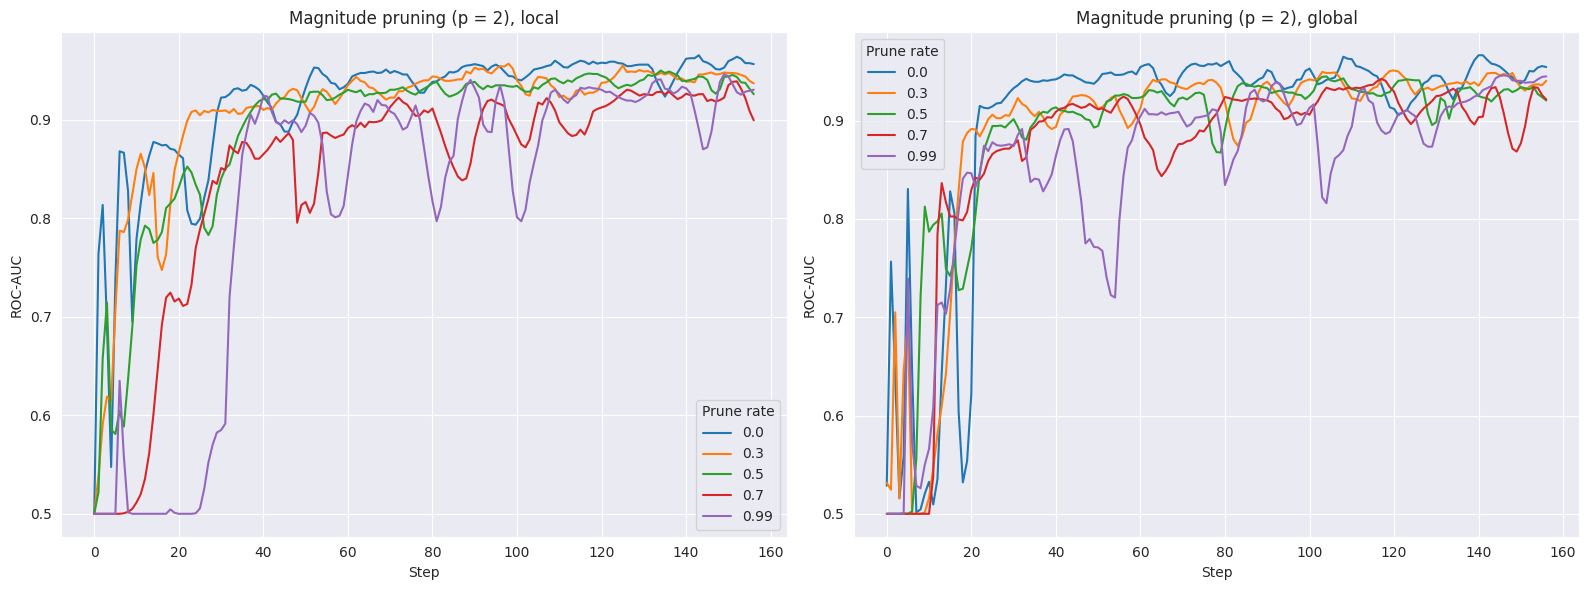

In [8]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 2), local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 2), global')

plt.tight_layout()

Возьмём L1-норму.

In [ ]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=1),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.GroupMagnitudeImportance(p=1),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

Построим графики.

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 1), local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Magnitude pruning (p = 1), global')

plt.tight_layout()

Теперь посмотрим на прунинг по Молчанову.

In [ ]:
history_local = []
history_global = []

prune_rate_grid = [0.0, 0.3, 0.5, 0.7, 0.99]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate, local'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.TaylorImportance(),
        prune_rate,
        global_pruning=False
        )
    
    history_local.append(
        train_loop(pruned_model, trainloader, testloader)
    )

for prune_rate in tqdm(prune_rate_grid, desc='prune rate, global'):
    pruned_model = depgraph_prune_model(
        model,
        tp.importance.TaylorImportance(),
        prune_rate,
        global_pruning=True
        )
    
    history_global.append(
        train_loop(pruned_model, trainloader, testloader)
    )

Построим графики.

In [ ]:
plt.figure(figsize=(8, 6))

for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)

plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning')


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for prune_rate, metric in zip(prune_rate_grid, history_local):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning, local')

plt.subplot(1, 2, 2)
for prune_rate, metric in zip(prune_rate_grid, history_global):
    plt.plot(metric, label=prune_rate)
plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Molchanov pruning, global')

plt.tight_layout()

### Эксперименты с pre-fineturning

Теперь будем сначала делать fineturning модели, потом - прунинг. Скачаем данные, создадим и обучим полную модель.

In [8]:
trainloader, testloader = get_dataloaders([8,9], batch_size=64)

full_model = resnet50(pretrained=True)
full_model.fc = torch.nn.Linear(full_model.fc.in_features, 2)
train_loop(full_model, trainloader, testloader)
full_model = full_model.to('cpu')

100%|██████████| 170M/170M [00:02<00:00, 61.4MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


  0%|          | 0/157 [00:00<?, ?it/s]

Попробуем сделать итеративный прунинг вплоть до полного.

In [9]:
results = depgraph_prune_model_and_validate(
        model=full_model,
        importance=tp.importance.TaylorImportance(),
        testloader=testloader,
        prune_rate=1,
        iterative_steps=50,
        check_pruning_rate=True,
        print_logs=True
    )

Base params: 23.51213 M
Round 1/50, Params: 22.09 M, Pruned: 6.05 %
Round 2/50, Params: 21.19 M, Pruned: 9.89 %
Round 3/50, Params: 20.65 M, Pruned: 12.18 %
Round 4/50, Params: 19.38 M, Pruned: 17.57 %
Round 5/50, Params: 18.58 M, Pruned: 20.98 %
Round 6/50, Params: 18.03 M, Pruned: 23.30 %
Round 7/50, Params: 17.14 M, Pruned: 27.11 %
Round 8/50, Params: 16.07 M, Pruned: 31.66 %
Round 9/50, Params: 15.54 M, Pruned: 33.91 %
Round 10/50, Params: 14.74 M, Pruned: 37.31 %
Round 11/50, Params: 13.75 M, Pruned: 41.52 %
Round 12/50, Params: 13.32 M, Pruned: 43.36 %
Round 13/50, Params: 12.51 M, Pruned: 46.78 %
Round 14/50, Params: 12.10 M, Pruned: 48.53 %
Round 15/50, Params: 11.21 M, Pruned: 52.34 %
Round 16/50, Params: 10.53 M, Pruned: 55.22 %
Round 17/50, Params: 10.10 M, Pruned: 57.04 %
Round 18/50, Params: 9.28 M, Pruned: 60.51 %
Round 19/50, Params: 8.64 M, Pruned: 63.23 %
Round 20/50, Params: 8.27 M, Pruned: 64.81 %
Round 21/50, Params: 7.75 M, Pruned: 67.03 %
Round 22/50, Params: 6.98

Визуализируем, что получилось.

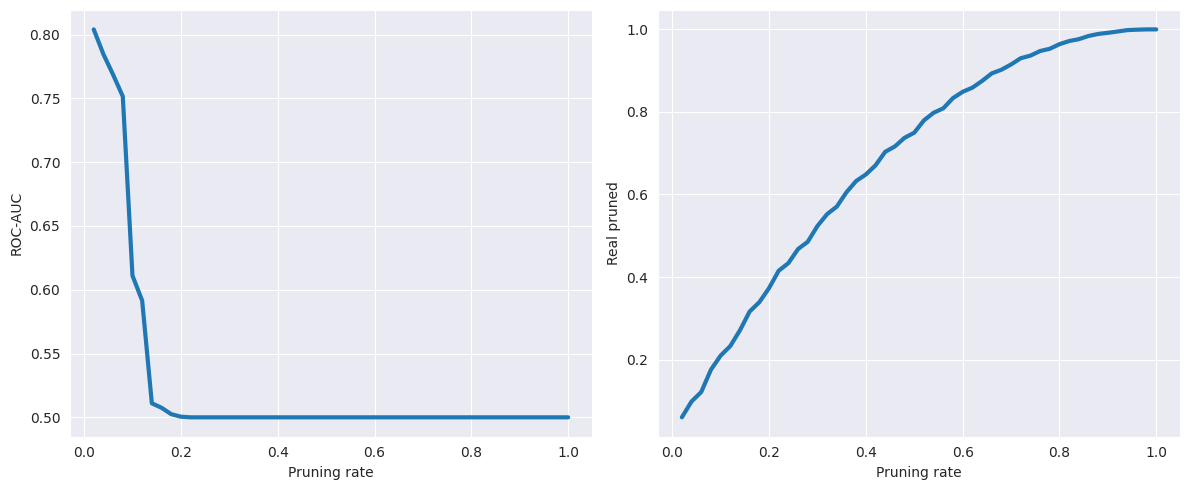

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results[1], results[0], lw=3)
plt.xlabel('Pruning rate')
plt.ylabel('ROC-AUC')

plt.subplot(1, 2, 2)
plt.plot(results[1], results[2], lw=3)
plt.xlabel('Pruning rate')
plt.ylabel('Real pruned')

plt.tight_layout()

**Вывод:** полный прунинг можно сделать итеративно. При этом метод валидации pruning rate не срабатывает.

Давайте посмотрим на метрику до и после прунинга. Создадим словари и переменные для экспериментов.

In [ ]:
importances = {
    'Magnitude, L2': tp.importance.GroupMagnitudeImportance(p=2),
    'Magnitude, L1': tp.importance.GroupMagnitudeImportance(p=1),
    'Taylor': tp.importance.TaylorImportance()
}

random_metric = test_loop(full_model, testloader, device='cpu') # before pruning

history = defaultdict(list)
history['full model'] = [random_metric] * len(importances)

eps = 1e-4  # for small pruning

Запустим эксперименты.

In [ ]:
for name_importance, importance in importances.items():
    history['importances'].append(name_importance)

    # Zero
    metrics, _ = depgraph_prune_model_and_validate(
        model=full_model,
        importance=importance,
        testloader=testloader,
        prune_rate=0
    )
    history['0.0'].append(metrics[0])

    # Small eps
    metrics, _ = depgraph_prune_model_and_validate(
        model=full_model,
        importance=importance,
        testloader=testloader,
        prune_rate=eps
    )
    history['1e-4'].append(metrics[0])

    # Other values
    metrics, prune_rates = depgraph_prune_model_and_validate(
        model=full_model,
        importance=importance,
        testloader=testloader,
        iterative_steps=10
    )
    for key, value in zip(prune_rates, metrics):
        history[str(key)].append(value)

Посмотрим на результаты.

In [34]:
pd.DataFrame(history).set_index('importances')

,full model,0.0,1e-4,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
importances,,,,,,,,,,,,,
"Magnitude, L2",0.9375,0.9375,0.9425,0.9475,0.9430,0.9420,0.9280,0.8615,0.5065,0.500,0.5,0.5,0.5
"Magnitude, L1",0.9375,0.9375,0.9400,0.9465,0.9525,0.9200,0.9030,0.8820,0.7855,0.682,0.5,0.5,0.5
Taylor,0.9375,0.9375,0.9270,0.9235,0.8995,0.7275,0.5005,0.5105,0.5000,0.500,0.5,0.5,0.5


### Ранговые корреляции оценок

Скачаем данные, создадим и обучим полную модель.

In [8]:
trainloader, testloader = get_dataloaders([8,9], batch_size=64)

full_model = resnet50(pretrained=True)
full_model.fc = torch.nn.Linear(full_model.fc.in_features, 2)
train_loop(full_model, trainloader, testloader)
full_model = full_model.to('cpu')

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


  0%|          | 0/157 [00:00<?, ?it/s]

Строим граф зависимостей.

In [78]:
DG = tp.DependencyGraph().build_dependency(full_model, example_inputs=torch.randn(1,3,224,224))

#### Без нормализатора

Создадим нужные нам объекты и переменные.

In [159]:
prune_rate = 0.15
num_samples = 100

importances = {
    'Magnitude, L2': tp.importance.GroupMagnitudeImportance(p=2, normalizer=None),
    'Magnitude, L1': tp.importance.GroupMagnitudeImportance(p=1, normalizer=None),
    'Taylor': tp.importance.TaylorImportance(normalizer=None)
}

history_metrics = {
    importance_name: {
        'random': [],
        'estimate': []
    } for importance_name in importances
    }

Запустим подсчёт метрик.

In [160]:
for _ in tqdm(range(num_samples), desc='sample'):
    for name_importance, importance in importances.items():
        random_importance = []
        calculated_importance = []
        random_scorer = AlmostRandomImportance()

        # Get importances
        for group in DG.get_all_groups():
            random_importance.extend(random_scorer(group))
            calculated_importance.extend(importance(group))
        
        # Calculate metric with random pruning
        random_metric = depgraph_prune_model_and_validate(
            model=full_model,
            importance=random_scorer,
            testloader=testloader,
            prune_rate=prune_rate
        )[0][0]

        # Calculate metric with importance
        calculated_importance = torch.tensor(calculated_importance)
        random_importance = torch.tensor(random_importance)
        threshold = torch.quantile(random_importance, prune_rate)
        mask = random_importance < threshold
        estimated_metric = (-calculated_importance[mask]).mean()

        # Save history
        history_metrics[name_importance]['random'].append(random_metric)
        history_metrics[name_importance]['estimate'].append(estimated_metric.item())

sample:   0%|          | 0/100 [00:00<?, ?it/s]

Построим графики для самопроверки и проверим корреляции.

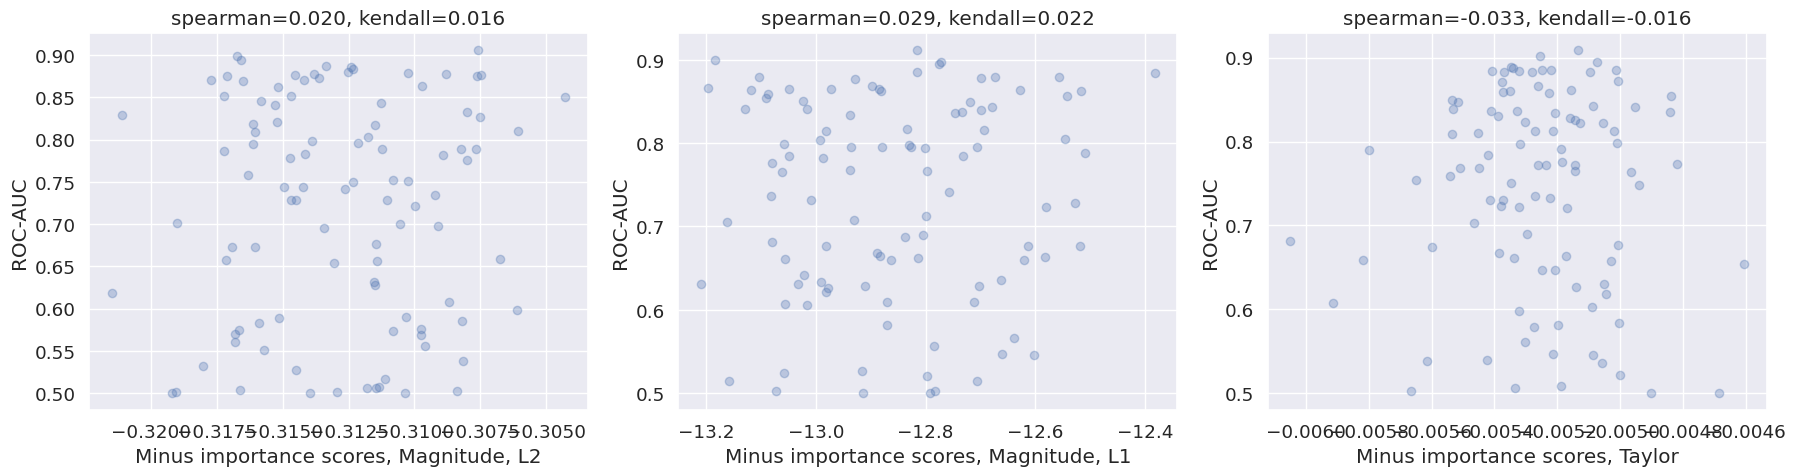

In [161]:
plt.figure(figsize=(18, 5))

for i, importance_name in enumerate(history_metrics):
    plt.subplot(1, 3, i+1)
    plt.scatter(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random'],
        alpha=0.3
        )
    plt.xlabel(f'Minus importance scores, {importance_name}')
    plt.ylabel('ROC-AUC')

    spearman_corr, _ = spearmanr(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )
    kendall_corr, _ = kendalltau(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )

    plt.title(f'spearman={spearman_corr:.3f}, kendall={kendall_corr:.3f}')

plt.tight_layout()

#### C нормализацией на среднее

Создадим нужные нам объекты и переменные.

In [10]:
prune_rate = 0.15
num_samples = 100

importances = {
    'Magnitude, L2': tp.importance.GroupMagnitudeImportance(p=2),
    'Magnitude, L1': tp.importance.GroupMagnitudeImportance(p=1),
    'Taylor': tp.importance.TaylorImportance()
}

history_metrics = {
    importance_name: {
        'random': [],
        'estimate': []
    } for importance_name in importances
    }

Запустим подсчёт метрик.

In [11]:
for _ in tqdm(range(num_samples), desc='sample'):
    for name_importance, importance in importances.items():
        random_importance = []
        calculated_importance = []
        random_scorer = AlmostRandomImportance()

        # Get importances
        for group in DG.get_all_groups():
            random_importance.extend(random_scorer(group))
            calculated_importance.extend(importance(group))
        
        # Calculate metric with random pruning
        random_metric = depgraph_prune_model_and_validate(
            model=full_model,
            importance=random_scorer,
            testloader=testloader,
            prune_rate=prune_rate
        )[0][0]

        # Calculate metric with importance
        calculated_importance = torch.tensor(calculated_importance)
        random_importance = torch.tensor(random_importance)
        threshold = torch.quantile(random_importance, prune_rate)
        mask = random_importance < threshold
        estimated_metric = (-calculated_importance[mask]).mean()

        # Save history
        history_metrics[name_importance]['random'].append(random_metric)
        history_metrics[name_importance]['estimate'].append(estimated_metric.item())

sample:   0%|          | 0/100 [00:00<?, ?it/s]

Построим графики для самопроверки и проверим корреляции.

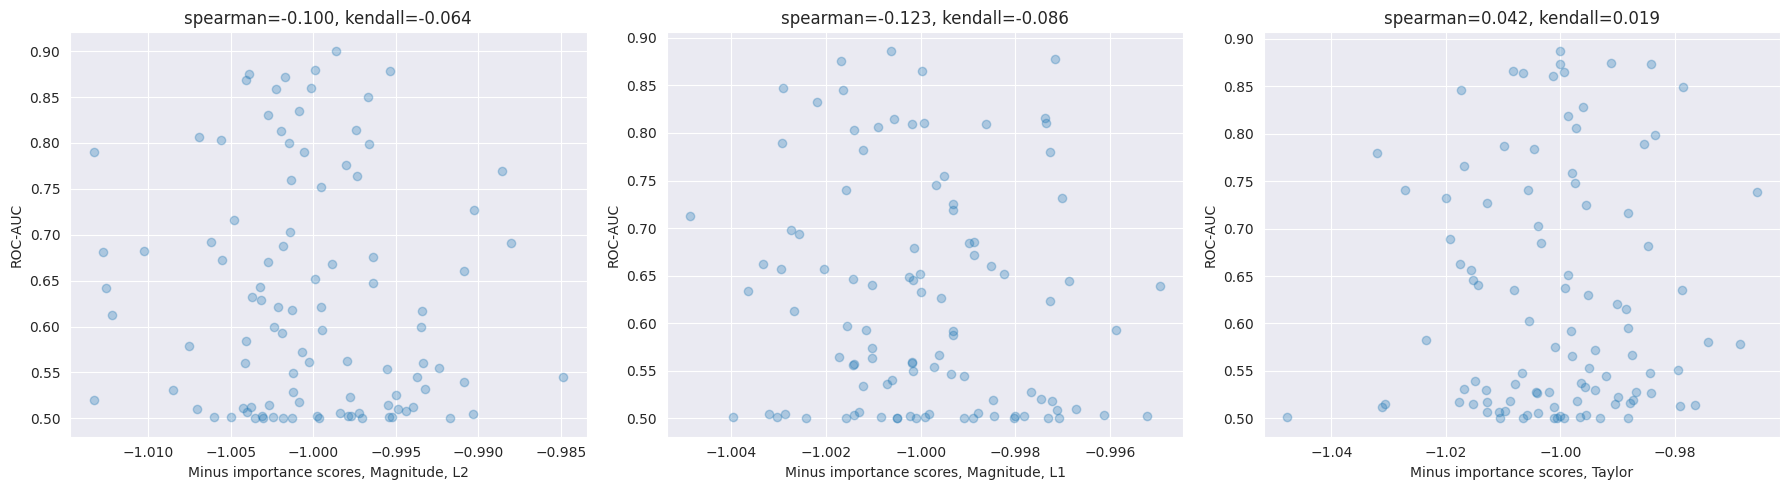

In [12]:
plt.figure(figsize=(18, 5))

for i, importance_name in enumerate(history_metrics):
    plt.subplot(1, 3, i+1)
    plt.scatter(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random'],
        alpha=0.3
        )
    plt.xlabel(f'Minus importance scores, {importance_name}')
    plt.ylabel('ROC-AUC')

    spearman_corr, _ = spearmanr(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )
    kendall_corr, _ = kendalltau(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )

    plt.title(f'spearman={spearman_corr:.3f}, kendall={kendall_corr:.3f}')

plt.tight_layout()

А что, если сдвинуть на единицу и отразить от нуля?

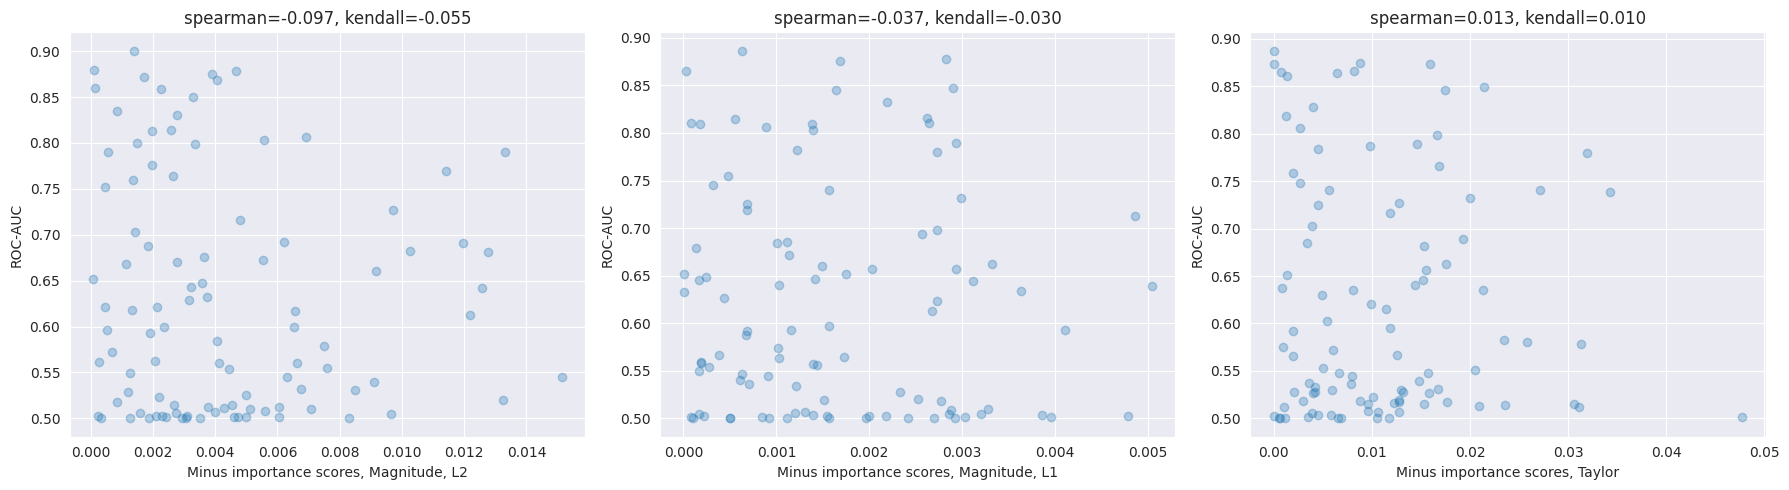

In [19]:
plt.figure(figsize=(18, 5))

for i, importance_name in enumerate(history_metrics):
    fixed_estimate = np.abs(np.array(history_metrics[importance_name]['estimate']) + 1)

    plt.subplot(1, 3, i+1)
    plt.scatter(
        fixed_estimate,
        history_metrics[importance_name]['random'],
        alpha=0.3
        )
    plt.xlabel(f'Minus importance scores, {importance_name}')
    plt.ylabel('ROC-AUC')

    spearman_corr, _ = spearmanr(
        fixed_estimate,
        history_metrics[importance_name]['random']
        )
    kendall_corr, _ = kendalltau(
        fixed_estimate,
        history_metrics[importance_name]['random']
        )

    plt.title(f'spearman={spearman_corr:.3f}, kendall={kendall_corr:.3f}')

plt.tight_layout()

#### С нормализацией, но только одна группа

Создадим нужные нам объекты и переменные.

In [111]:
prune_rate = 0.15
num_samples = 1000

importances = {
    'Magnitude, L2': tp.importance.GroupMagnitudeImportance(p=2),
    'Magnitude, L1': tp.importance.GroupMagnitudeImportance(p=1),
    'Taylor': tp.importance.TaylorImportance()
}

history_metrics = {
    importance_name: {
        'random': [],
        'estimate': []
    } for importance_name in importances
    }

criterion = torch.nn.CrossEntropyLoss()
example_inputs = torch.randn(1, 3, 224, 224)

Соберём все группы. Это немного костыль, но я не придумал, как по-другому взять группу со *всеми* индексами.

In [112]:
all_groups = list(DG.get_all_groups())

Выберем группу для второго слоя.

In [113]:
group_layer2 = all_groups[3]

Запустим подсчёт метрик.

In [114]:
for _ in tqdm(range(num_samples), desc='sample'):
    for name_importance, importance in importances.items():
        # Get importances
        random_scorer = AlmostRandomImportance()
        random_importance = random_scorer(group_layer2)
        calculated_importance = importance(group_layer2)

        # Make a copy of model for prune
        model_copy = copy.deepcopy(full_model)

        # Initialize a pruner with the model and the importance criterion
        ignored_layers = []
        for m in model_copy.modules():
            if isinstance(m, torch.nn.Linear) and m.out_features == 2:
                ignored_layers.append(m) # DO NOT prune the final classifier!

        pruner = tp.pruner.BasePruner( # We can always choose BasePruner if sparse training is not required.
            model=model_copy,  # A to-be-pruned model
            example_inputs=example_inputs,  # dummy inputs for graph tracing
            importance=random_scorer,  # importance estimator
            pruning_ratio=0,  # global channel sparisty. Also known as pruning ratio.
            pruning_ratio_dict = {model_copy.layer2: prune_rate},  # for prune only one group
            ignored_layers=ignored_layers,
            round_to=8, # It's recommended to round dims/channels to 4x or 8x for acceleration. Please see: https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html
        )

        # Prune the model
        pruner.step()
        
        # Calculate metric with random pruning
        random_metric = test_loop(model_copy, testloader, device='cuda')

        # Calculate metric with importance
        threshold = torch.quantile(random_importance, prune_rate)
        mask = random_importance < threshold
        estimated_metric = (-calculated_importance[mask]).mean()

        # Save history
        history_metrics[name_importance]['random'].append(random_metric)
        history_metrics[name_importance]['estimate'].append(estimated_metric.item())

sample:   0%|          | 0/1000 [00:00<?, ?it/s]

Построим графики для самопроверки и проверим корреляции.

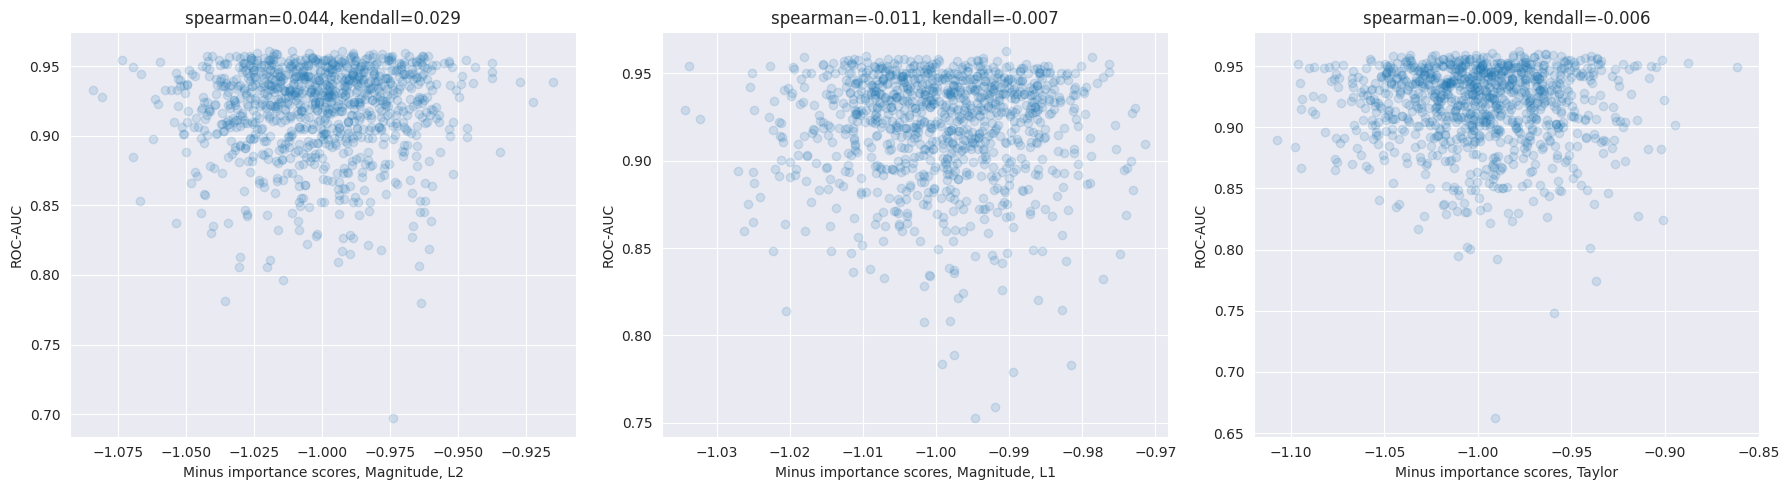

In [116]:
plt.figure(figsize=(18, 5))

for i, importance_name in enumerate(history_metrics):
    plt.subplot(1, 3, i+1)
    plt.scatter(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random'],
        alpha=0.15
        )
    plt.xlabel(f'Minus importance scores, {importance_name}')
    plt.ylabel('ROC-AUC')

    spearman_corr, _ = spearmanr(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )
    kendall_corr, _ = kendalltau(
        history_metrics[importance_name]['estimate'],
        history_metrics[importance_name]['random']
        )

    plt.title(f'spearman={spearman_corr:.3f}, kendall={kendall_corr:.3f}')

plt.tight_layout()

### Простая суррогатная модель

Скачаем данные, создадим и обучим полную модель.

In [8]:
trainloader, testloader = get_dataloaders([8,9], batch_size=64)

full_model = resnet50(pretrained=True)
full_model.fc = torch.nn.Linear(full_model.fc.in_features, 2)
train_loop(full_model, trainloader, testloader)
full_model = full_model.to('cpu')

100%|██████████| 170M/170M [00:02<00:00, 74.0MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s] 


  0%|          | 0/157 [00:00<?, ?it/s]

Строим граф зависимостей.

In [9]:
DG = tp.DependencyGraph().build_dependency(full_model, example_inputs=torch.randn(1,3,224,224))

#### Датасет

Соберём датасет пар `(mask, metric)`. Сначала зададим нужные переменные и массивы.

In [25]:
prune_rate = 0.15
num_samples = 100

random_metrics = []
masks = []

Семплируем модели и собираем данные.

In [26]:
for _ in tqdm(range(num_samples), desc='sample'):
    random_importance = []
    random_scorer = AlmostRandomImportance()

    # Get importances
    for group in DG.get_all_groups():
        random_importance.extend(random_scorer(group))
    
    # Calculate metric with random pruning
    random_metric = depgraph_prune_model_and_validate(
        model=full_model,
        importance=random_scorer,
        testloader=testloader,
        prune_rate=prune_rate
    )[0][0]

    # Generate masks
    random_importance = torch.tensor(random_importance)
    threshold = torch.quantile(random_importance, prune_rate)
    mask = random_importance < threshold

    # Save history
    random_metrics.append(random_metric)
    masks.append(mask.numpy().astype(int))

sample:   0%|          | 0/100 [00:00<?, ?it/s]

Изменим размерности и приведём к массивам numpy.

In [37]:
masks = np.array(masks)
random_metrics = np.reshape(random_metrics, (-1, 1))

Создадим и сохраним датасет.

In [44]:
data = pd.DataFrame(
    np.append(
        masks,
        random_metrics, axis=1)
        ).rename(columns={11458: 'metric'})
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11449,11450,11451,11452,11453,11454,11455,11456,11457,metric
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5135
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5515
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.8350


In [45]:
data.to_csv('mask2metric.csv', index=False)

#### Данные

In [137]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import roc_auc_score

Загрузим данные.

In [119]:
data = pd.read_csv('/kaggle/input/pruning-mask2metric/mask2metric.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11449,11450,11451,11452,11453,11454,11455,11456,11457,metric
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5135
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5515
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.8350


#### Линейная регрессия

Делим на признаки и таргет.

In [11]:
X = data.drop(columns=['metric'])
X = sm.add_constant(X)
y = data['metric']

Делим на тест и трейн.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Создадим и обучим модель.

In [17]:
model = sm.OLS(y_train, X_train)
results = model.fit()
with open('ols_results.txt', 'w') as f:
    f.write(str(results.summary()))

/home/pgn55555/.local/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/pgn55555/.local/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/pgn55555/.local/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


Сделаем предсказание, посчитаем MAPE.

In [26]:
y_pred = results.predict(X_train)
print(f'Train MAPE:\t{mape(y_train, y_pred):.5f}')

y_pred = results.predict(X_test)
print(f'Test MAPE:\t{mape(y_test, y_pred):.5f}')

Train MAPE:	0.00000
Test MAPE:	0.19633


#### Логистическая регрессия

Делим на признаки и таргет.

In [240]:
X = data.drop(columns=['metric'])
y = data['metric']

Делим на тест и трейн.

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Попробуем выбрать трешхолд для логрегрессии (мне не очень нравится этот шаг).

In [243]:
threshold = y.median()
y_bin_train = np.where(y_train > threshold, 1, 0)
y_bin_test = np.where(y_test > threshold, 1, 0)

Создадим и обучим модель.

In [244]:
model = LogisticRegression()
model.fit(X_train, y_bin_train)

LogisticRegression()

Сделаем предсказание, посчитаем ROC-AUC.

In [248]:
y_prob = model.predict_proba(X_train)
print(f'Train ROC-AUC:\t{roc_auc_score(y_bin_train, y_prob[:, 1]):.5f}')

y_prob = model.predict_proba(X_test)
print(f'Test ROC-AUC:\t{roc_auc_score(y_bin_test, y_prob[:, 1]):.5f}')
print(f'Test MAPE:\t{mape(y_test, y_prob[:, 1]):.5f}')

Train ROC-AUC:	1.00000
Test ROC-AUC:	0.72000
Test MAPE:	0.28187


#### Простая нейросеть

In [221]:
from torch.utils.data import DataLoader, TensorDataset

Делим на признаки и таргет.

In [222]:
X = data.drop(columns=['metric'])
y = data['metric']

Делим на тест и трейн.

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Зададим датасет и даталоадер.

In [224]:
train_dataset = TensorDataset(
    torch.tensor(X_train.to_numpy()).float(),
    torch.tensor(y_train.to_numpy()).unsqueeze(1).float()
    )
test_dataset = TensorDataset(
    torch.tensor(X_test.to_numpy()).float(),
    torch.tensor(y_test.to_numpy()).unsqueeze(1).float()
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Создадим модель.

In [233]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

Зададим критерий и оптимизатор.

In [237]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

Обучим нейросеть.

In [238]:
n_epochs = 100

model.train()

for epoch in range(1, n_epochs + 1):
    total_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 10/100, Loss: 0.6364
Epoch 20/100, Loss: 0.6384
Epoch 30/100, Loss: 0.6325
Epoch 40/100, Loss: 0.6292
Epoch 50/100, Loss: 0.6110
Epoch 60/100, Loss: 0.6097
Epoch 70/100, Loss: 0.6013
Epoch 80/100, Loss: 0.5978
Epoch 90/100, Loss: 0.6057
Epoch 100/100, Loss: 0.5951


Сделаем предсказание, посчитаем MAPE.

In [239]:
model.eval()
with torch.no_grad():
    test_data = torch.tensor(X_test.to_numpy()).unsqueeze(0).float()
    outputs = model(test_data)

print(f'Test MAPE:\t{mape(y_test, outputs.squeeze()):.5f}')

Test MAPE:	0.15314
